In [47]:
%matplotlib inline
import os
import os.path as osp
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
import celldom
from celldom.core.experiment import Experiment
from celldom.config.experiment_config import get_exp_config_by_name

EXP_NAME = 'exp-20180217-G1-K562-control-01'
COUNT_DATA_DIR = osp.join(celldom.get_dataset_dir(), 'dataset06', 'manual_counting')
XLS_FILE = osp.join(COUNT_DATA_DIR, 'G1 35 K562 IMDM Tests - summary.xlsx')
#OUTPUT_DIR = osp.join(celldom.get_data_dir(), 'output', '20181003-G1-full')
OUTPUT_DIR = osp.join(celldom.get_data_dir(), 'output', '20181003-G1-full-bkp')

XLS_FILE, OUTPUT_DIR

('/lab/data/celldom/dataset/dataset06/manual_counting/G1 35 K562 IMDM Tests - summary.xlsx',
 '/lab/data/celldom/output/20181003-G1-full-bkp')

In [48]:
exp = Experiment(get_exp_config_by_name(EXP_NAME), OUTPUT_DIR)

In [49]:
!pip install xlrd
d = pd.read_excel(XLS_FILE, sheet_name=None)
d.keys()

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


odict_keys(['Data Summary', 'Count Summary', 'Heatmap Sumary 0-63 hr', 'Test 2 Heatmap (0 hr)', 'Test 2 Heatmap (17 hr)', 'Test 2 Heatmap (41 hr)', 'Test 2 Heatmap (63 hr)', 'Heatmap Sumary 0-63 hr (3)', 'Heatmap Sumary 0-63 hr (2)'])

#### Load Validation Data

In [76]:
def get_true_count_data():
    df = (
        pd.read_excel(XLS_FILE, sheet_name='Count Summary', header=3)
        .assign(apt_num=lambda d: d['Apt'].apply(lambda v: '{:02d}'.format(v)))
        .assign(st_num=lambda d: d['Street'].apply(lambda v: '{:02d}'.format(v)))
        .drop(['Apt', 'Street'], axis=1)
        .reset_index(drop=True).set_index(['apt_num', 'st_num'])
    )
    df.columns.name = 'hours_str'
    df = df.stack().rename('cell_count').reset_index()
    df['hours'] = df['hours_str'].apply(lambda v: int(v.split()[0]))
    
    # Cell counts are floats at this point, and convert to int carefully
    assert (df['cell_count'].round() == dft['cell_count']).all()
    df['cell_count'] = df['cell_count'].astype(int)
    return df

dft = get_true_count_data()
dft.info()
dft.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 5 columns):
apt_num       1512 non-null object
st_num        1512 non-null object
hours_str     1512 non-null object
cell_count    1512 non-null int64
hours         1512 non-null int64
dtypes: int64(2), object(3)
memory usage: 59.1+ KB


,apt_num,st_num,hours_str,cell_count,hours
0,00,31,0 hr,1,0
1,00,31,17 hr,1,17
2,00,31,41 hr,1,41
3,00,31,63 hr,1,63
4,00,30,0 hr,1,0


In [77]:
dft.groupby('hours').size()

hours
0     378
17    378
41    378
63    378
dtype: int64

In [78]:
dft['cell_count'].describe()

count    1512.000000
mean        2.600529
std         4.254535
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        40.000000
Name: cell_count, dtype: float64

In [79]:
dft['st_num'].max(), dft['apt_num'].max()

('31', '11')

#### Load Predicted Data

In [80]:
def get_pred_count_data():

    df = exp.get_data_store().get('apartment')

    # *IMPORTANT* transpose the st/apt interpretation intentionally reversed in processing to
    # comply with convention used in manual counts
    df = df.rename(columns={'apt_num': 'temp'})
    df = df.rename(columns={'st_num': 'apt_num', 'temp': 'st_num'})

    df = df[['apt_num', 'st_num', 'acq_hours', 'cell_count']]
    df['hours_str'] = df['acq_hours'].apply(lambda v: '{} hr'.format(v))
    df['hours'] = df['acq_hours'].astype(int)
    df = df.drop(['acq_hours'], axis=1)

    # Group by apartment + time and compute median cell count (rounded)
    df = df.groupby(['apt_num', 'st_num', 'hours', 'hours_str'])['cell_count'].median()\
        .rename('cell_count').round().astype(int).reset_index()
    
    return df

dfp = get_pred_count_data()
dfp.info()
dfp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13314 entries, 0 to 13313
Data columns (total 5 columns):
apt_num       13314 non-null object
st_num        13314 non-null object
hours         13314 non-null int64
hours_str     13314 non-null object
cell_count    13314 non-null int64
dtypes: int64(2), object(3)
memory usage: 520.2+ KB


,apt_num,st_num,hours,hours_str,cell_count
0,00,00,0,0 hr,1
1,00,00,17,17 hr,4
2,00,00,41,41 hr,6
3,00,00,63,63 hr,20
4,00,00,71,71 hr,25


In [82]:
dfp.groupby('hours').size()

hours
0      1476
17     1479
41     1481
63     1477
71     1479
78     1480
88     1481
100    1479
117    1482
dtype: int64

In [83]:
dfp['cell_count'].describe()

count    13314.000000
mean         3.058885
std          8.599748
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max        101.000000
Name: cell_count, dtype: float64

In [88]:
pd.concat([
    dfp['st_num'].value_counts().sort_index(),
    dfp['apt_num'].value_counts().sort_index()
], axis=1)

,st_num,apt_num
00,284,423.0
01,279,423.0
02,288,423.0
03,279,423.0
04,288,423.0
05,279,423.0
06,287,423.0
07,279,423.0
08,288,423.0
09,279,423.0


### Merge

In [108]:
df = pd.merge(
    dft.rename(columns={'cell_count': 'true_ct'}), 
    dfp.rename(columns={'cell_count': 'pred_ct'}), 
    on=['apt_num', 'st_num', 'hours', 'hours_str'], 
    how='left'
)
df['delta_ct'] = df['true_ct'] - df['pred_ct']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512 entries, 0 to 1511
Data columns (total 7 columns):
apt_num      1512 non-null object
st_num       1512 non-null object
hours_str    1512 non-null object
true_ct      1512 non-null int64
hours        1512 non-null int64
pred_ct      1512 non-null int64
delta_ct     1512 non-null int64
dtypes: int64(4), object(3)
memory usage: 94.5+ KB


,apt_num,st_num,hours_str,true_ct,hours,pred_ct,delta_ct
0,00,31,0 hr,1,0,2,-1
1,00,31,17 hr,1,17,0,1
2,00,31,41 hr,1,41,1,0
3,00,31,63 hr,1,63,3,-2
4,00,30,0 hr,1,0,0,1


In [109]:
df['hours'].value_counts()

63    378
41    378
17    378
0     378
Name: hours, dtype: int64

In [126]:
# Total number of cells across array subset by hour
df.groupby('hours')[['pred_ct', 'true_ct']].sum()

,pred_ct,true_ct
hours,,
0,287,294
17,423,520
41,637,1038
63,980,2080


In [110]:
# Prediction difference distributions by hour
df.groupby('hours')['delta_ct'].describe()

,count,mean,std,min,25%,50%,75%,max
hours,,,,,,,,
0,378.0,0.018519,0.948082,-5.0,-1.0,0.0,1.0,5.0
17,378.0,0.256614,1.740536,-8.0,-1.0,0.0,1.0,8.0
41,378.0,1.060847,3.558380,-12.0,-1.0,1.0,3.0,15.0
63,378.0,2.910053,8.097048,-29.0,-1.0,1.0,7.0,38.0


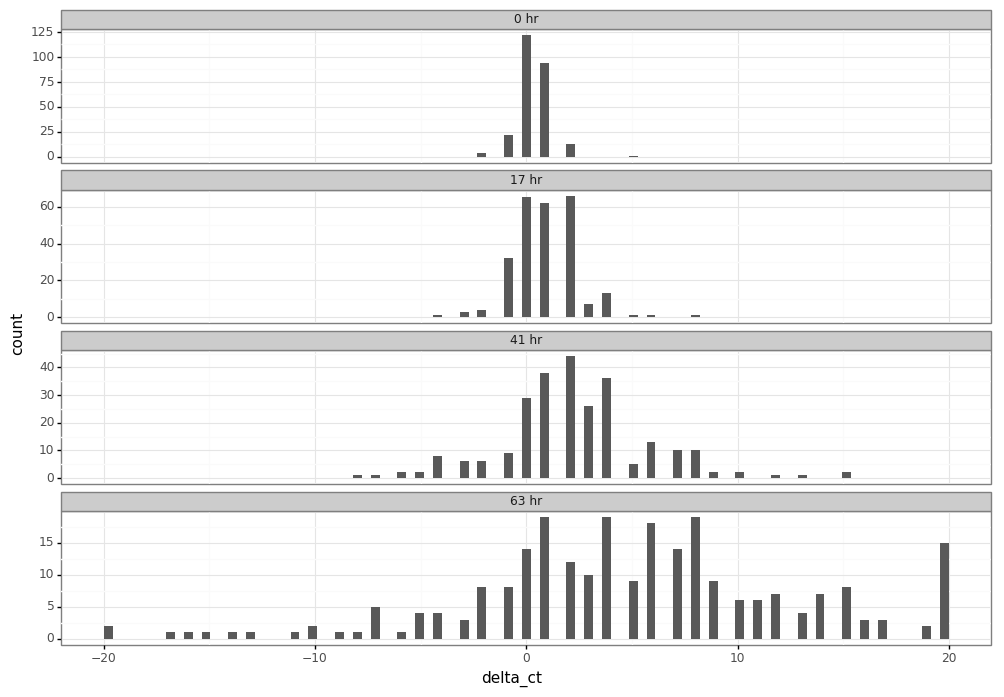

<ggplot: (-9223363280034623421)>

In [124]:
dfplt = df.assign(delta_ct=df.delta_ct.clip(-20, 20))
dfplt = dfplt[dfplt['true_ct'] != 0]
(
    pn.ggplot(dfplt, pn.aes(x='delta_ct')) +
    pn.geom_histogram(bins=96) +
    pn.facet_wrap('~hours_str', ncol=1, scales='free_y') +
    pn.theme_bw() +
    pn.theme(figure_size=(12, 8))
)

In [104]:
cts = df.groupby(['true_ct', 'pred_ct']).size().unstack()
cts = cts.reindex(
    columns=pd.Int64Index(np.arange(cts.columns.min(), cts.columns.max()+1)), 
    index=pd.Int64Index(np.arange(cts.index.min(), cts.index.max()+1))
)
cts = cts.stack().reset_index()
cts.columns = ['true_ct', 'pred_ct', 'count']
cts['log_count'] = np.log10(cts['count'])
cts.head()

,true_ct,pred_ct,count,log_count
0,0,0,217.0,2.336460
1,0,1,126.0,2.100371
2,0,2,95.0,1.977724
3,0,3,17.0,1.230449
4,0,4,17.0,1.230449


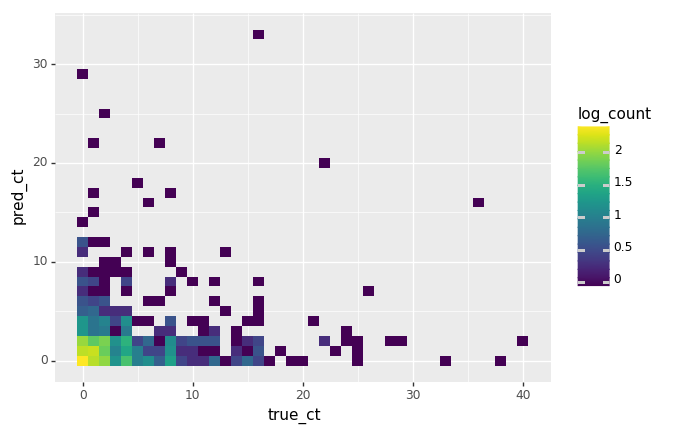

<ggplot: (8756821716456)>

In [105]:
(
    pn.ggplot(cts, pn.aes(x='true_ct', y='pred_ct', fill='log_count')) +
    pn.geom_tile()
)